## MNIST with torchvision and skorch

## Example with Pytorch

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets,transforms 

In [73]:
DEVICE = torch.device("cpu")

In [74]:
train_dataset = torchvision.datasets.MNIST('classifier_data', train=True, download=True)
test_dataset  = torchvision.datasets.MNIST('classifier_data', train=False, download=True)

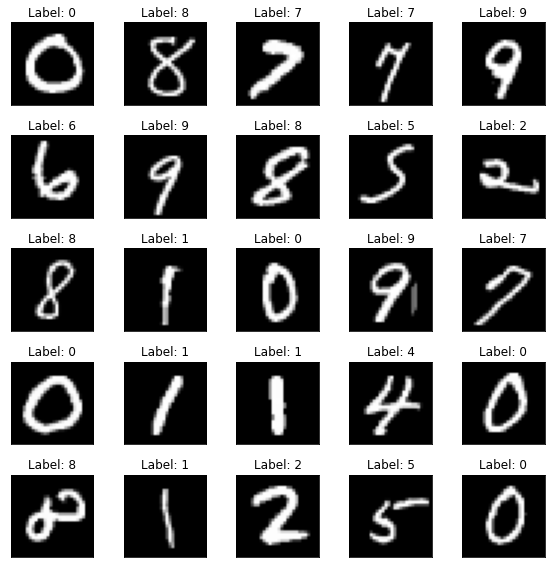

In [75]:
import random

fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    img, label = random.choice(train_dataset)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

In [76]:
transform = transforms.Compose([
    torchvision.transforms.ToTensor()
])
# Set the train transform
train_dataset.transform = transform
# Set the test transform
test_dataset.transform = transform

In [77]:
m=len(train_dataset)
train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=64)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64,shuffle=True)

In [78]:
class ConvNet(nn.Module):
    def __init__(self,dropout_rate=0.4,dropout_rate2=0.2,l1=50):
        # We optimize dropout rate in a convolutional neural network.
        super(ConvNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.drop1=nn.Dropout2d(p=dropout_rate)   

        self.fc1 = nn.Linear(32 * 7 * 7, l1)
        self.drop2=nn.Dropout2d(p=dropout_rate2)

        self.fc2 = nn.Linear(l1, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x),kernel_size = 2))

        x = F.relu(F.max_pool2d(self.conv2(x),kernel_size = 2))
        x = self.drop1(x)

        x = x.view(x.size(0),-1)

        x = F.relu(self.fc1(x))
        x = self.drop2(x)

        x = self.fc2(x)

        return x

In [79]:
model = ConvNet()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

criterion= nn.CrossEntropyLoss()

In [80]:
valid_loss_min = np.Inf
train_loss_history=[]
val_loss_history=[]
train_acc_history=[]
val_acc_history=[]

num_epochs=10
#dataset_sizes = {'train':len(train_dataset),'val':len(val_dataset),'test':len(test_dataset)}

for epoch in range(num_epochs):
    
    train_loss = 0.0
    train_correct = 0
    
    
    # Training
    model.train()
    for idx, (images, labels) in enumerate(train_loader):
        
        images,labels=images.to(DEVICE),labels.to(DEVICE)
        optimizer.zero_grad() 
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
        scores, predictions = torch.max(output.data, 1)
        train_correct += (predictions == labels).sum().item()
    
    valid_loss=0.0
    val_correct = 0
    #Validate Model
    model.eval()
    for idx, (images, labels) in enumerate(valid_loader):
        
        images,labels=images.to(DEVICE),labels.to(DEVICE)
        output = model(images)
        loss = criterion(output, labels)
        valid_loss += loss.item()*images.size(0)
        scores, predictions = torch.max(output.data, 1)
        val_correct += (predictions == labels).sum().item()
    
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    acc = train_correct/len(train_loader.sampler) * 100
    val_acc = val_correct/len(valid_loader.sampler) * 100
    
    train_loss_history.append(train_loss)
    val_loss_history.append(valid_loss)
    train_acc_history.append(acc)
    val_acc_history.append(val_acc)
    
    print("Epoch:{}/{} \t TL:{:.4f} \t VL:{:.4f} \t TA:{:.2f} %  \t  VA:{:.2f} %".format(epoch+1,num_epochs, 
                                                      train_loss,
                                                      valid_loss,
                                                      acc,
                                                      val_acc))
    
    # Save the best possible model
    if valid_loss < valid_loss_min:
        print("Saving Model")
        torch.save(model.state_dict(), 'CLIRF100_Weights.pt')
        valid_loss_min = valid_loss

KeyboardInterrupt: 

## Skorch

In [81]:
pip install skorch

Note: you may need to restart the kernel to use updated packages.


In [82]:
from skorch import NeuralNetClassifier

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets,transforms 

from skorch import NeuralNetClassifier

In [87]:
DEVICE = torch.device("cpu")

In [107]:
class ConvNet(nn.Module):
    def __init__(self,dropout_rate=0.4,dropout_rate2=0.2,l1=50):
        # We optimize dropout rate in a convolutional neural network.
        super(ConvNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.drop1=nn.Dropout2d(p=dropout_rate)  
        
        self.fc1 = nn.Linear(32 * 7 * 7, l1)
        self.drop2=nn.Dropout2d(p=dropout_rate2)
        
        self.fc2 = nn.Linear(l1, 10)

    def forward(self, x):
        
        x = F.relu(F.max_pool2d(self.conv1(x),kernel_size = 2))
        
        x = F.relu(F.max_pool2d(self.conv2(x),kernel_size = 2))
        x = self.drop1(x)
        
        x = x.view(x.size(0),-1)
        x = F.relu(self.fc1(x))
        
        x = self.drop2(x)
        x = self.fc2(x)
        return x

In [ ]:
for i, data in enumerate(train_dataset): # i == Index
   x_train, y_train = data

In [109]:
y_train = np.array([y for x, y in iter(train_dataset)])

In [127]:
torch.manual_seed(0)

net = NeuralNetClassifier(
    ConvNet,
    max_epochs=10,
    iterator_train__num_workers=4,
    iterator_valid__num_workers=4,
    lr=1e-3,
    batch_size=64,
    optimizer=optim.Adam,
    criterion=nn.CrossEntropyLoss,
    #iterator_train__shuffle=True,
    device=DEVICE
)

In [111]:
net.fit(train_dataset, y=y_train);

  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.3938       0.9687        0.1036  27.2863
      2        0.1315       0.9786        0.0720  26.7937
      3        0.0951       0.9799        0.0656  24.0168
      4        0.0818       0.9856        0.0498  23.6597
      5        0.0703       0.9882        0.0454  24.3216
      6        0.0641       0.9867        0.0451  23.7894
      7        0.0574       0.9894        0.0397  23.9339
      8        0.0515       0.9877        0.0428  23.4776
      9        0.0490       0.9888        0.0388  23.5736
     10        0.0441       0.9897        0.0387  24.2062


## Prediction

In [112]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

In [113]:
y_pred = net.predict(test_dataset)
y_test = np.array([y for x, y in iter(test_dataset)])

In [114]:
accuracy_score(y_test, y_pred)

0.9909

## K cross validation

In [115]:
from torch.utils.data import ConcatDataset

In [116]:
dataset = ConcatDataset([train_dataset, test_dataset])

In [117]:
y = np.array([y for x, y in iter(dataset)])

In [118]:
from skorch.helper import SliceDataset

mnist_sliceable = SliceDataset(dataset)

In [119]:
scores = cross_val_score(net, mnist_sliceable,y, cv = 5, scoring = "accuracy")

  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.4246       0.9696        0.0970  21.1449
      2        0.1446       0.9760        0.0767  20.7069
      3        0.1115       0.9806        0.0631  21.9985
      4        0.0936       0.9853        0.0528  21.0511
      5        0.0799       0.9867        0.0481  20.3950
      6        0.0712       0.9868        0.0474  22.1718
      7        0.0655       0.9867        0.0441  21.3280
      8        0.0596       0.9883        0.0438  20.3631
      9        0.0536       0.9881        0.0428  21.1490
     10        0.0502       0.9888        0.0427  21.2473
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.4231       0.9650        0.1140  21.7901
      2        0.1359       0.9744        0.0851  20.2716
      3        0.1039       0.9783        0.0726  20.7452
      4       

In [120]:
print(scores)
print(scores.mean())

[0.98778571 0.98892857 0.98842857 0.986      0.99021429]
0.9882714285714286


## GridSearch

In [121]:
from sklearn.model_selection import GridSearchCV

In [128]:
net.set_params(callbacks=[])

<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=<class '__main__.ConvNet'>,
)

In [129]:
params = {
    'module__l1':[50,60,70],
    'module__dropout':[0,0.3,0.5],
}

In [130]:
gs = GridSearchCV(net, params, cv=3, scoring='accuracy')

In [131]:
from skorch.helper import SliceDataset

mnist_train_sliceable = SliceDataset(train_data)

In [132]:
#gs.fit(mnist_train_sliceable, y=y_train)

ValueError: Found input variables with inconsistent numbers of samples: [48000, 60000]

In [ ]:
print(gs.best_score_, gs.best_params_)